In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, log_loss, make_scorer, f1_score

from main import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and Convert

In [49]:
df = pd.read_csv('data/churn_train.csv')

In [50]:
df = conversion(df)

# Missing Values

In [51]:
ttest_by(df.avg_dist, pd.isnull(df.avg_rating_by_driver))

Ttest_indResult(statistic=1.2193684641273346, pvalue=0.22271156421529795)

In [52]:
ttest_by(df.avg_dist, pd.isnull(df.avg_rating_of_driver))

Ttest_indResult(statistic=26.0119633761209, pvalue=6.194561708260528e-148)

In [53]:
# since avg_rating_by_driver missing and not missing populations are the same, we do not reject the
# null hypothesis, and we could safely remove the missing values from that column. also the amount of missing
# data is relatively small.
#
# the two populations of avg_rating_of_driver are different, so removing these values would be harmful
# to the final model. also there's a large number of missing values which makes removal problematic.

In [54]:
df = fix_missing(df)

# Feature Engineering

In [55]:
df = feature_engineering(df)

# Indicator Columns

In [56]:
df = create_indicator_columns(df)

# Analysis

In [57]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,...,"by_drv_(-0.001, 2.99]","by_drv_(2.99, 3.99]","by_drv_(3.99, 4.99]","by_drv_(4.99, 5.0]",by_drv_missing,"of_drv_(-0.001, 2.99]","of_drv_(2.99, 3.99]","of_drv_(3.99, 4.99]","of_drv_(4.99, 5.0]",of_drv_missing
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,...,0,0,0,1,0,0,0,0,1,0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,...,0,0,0,1,0,0,0,0,1,0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,...,0,0,1,0,0,0,0,0,0,1
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,...,0,0,0,1,0,0,0,0,0,1
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,...,0,0,0,1,0,0,0,0,0,1


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39838 entries, 0 to 39999
Data columns (total 31 columns):
avg_dist                    39838 non-null float64
avg_rating_by_driver        39838 non-null float64
avg_rating_of_driver        33367 non-null float64
avg_surge                   39838 non-null float64
city                        39838 non-null object
last_trip_date              39838 non-null datetime64[ns]
phone                       39838 non-null object
signup_date                 39838 non-null datetime64[ns]
surge_pct                   39838 non-null float64
trips_in_first_30_days      39838 non-null int64
luxury_car_user             39838 non-null bool
weekday_pct                 39838 non-null float64
bin_avg_rating_by_driver    39838 non-null category
bin_avg_rating_of_driver    39838 non-null category
churned                     39838 non-null bool
Android                     39838 non-null uint8
No Phone                    39838 non-null uint8
iPhone                

In [59]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,39838.0,5.789083,5.655508,0.0,2.42,3.89,6.93,129.89
avg_rating_by_driver,39838.0,4.777434,0.448088,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,33367.0,4.601987,0.613463,1.0,4.30,4.90,5.00,5.00
avg_surge,39838.0,1.074524,0.220562,1.0,1.00,1.00,1.05,8.00
surge_pct,39838.0,8.823912,19.905032,0.0,0.00,0.00,8.50,100.00
trips_in_first_30_days,39838.0,2.287665,3.817305,0.0,0.00,1.00,3.00,125.00
weekday_pct,39838.0,60.906052,37.025108,0.0,33.30,66.70,100.00,100.00
Android,39838.0,0.301345,0.458848,0.0,0.00,0.00,1.00,1.00
No Phone,39838.0,0.007957,0.088849,0.0,0.00,0.00,0.00,1.00
iPhone,39838.0,0.690697,0.462212,0.0,0.00,1.00,1.00,1.00


In [60]:
df.phone.value_counts()

iPhone      27516
Android     12005
No Phone      317
Name: phone, dtype: int64

In [61]:
df.churned.value_counts()

True     24838
False    15000
Name: churned, dtype: int64

In [62]:
pd.crosstab(df.phone, df.city)

city,Astapor,King's Landing,Winterfell
phone,,,
Android,4203,2018,5784
No Phone,98,53,166
iPhone,8890,6040,12586


In [63]:
df.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churned,Android,...,"by_drv_(-0.001, 2.99]","by_drv_(2.99, 3.99]","by_drv_(3.99, 4.99]","by_drv_(4.99, 5.0]",by_drv_missing,"of_drv_(-0.001, 2.99]","of_drv_(2.99, 3.99]","of_drv_(3.99, 4.99]","of_drv_(4.99, 5.0]",of_drv_missing
avg_dist,1.000000,0.082303,0.037380,-0.079519,-0.102423,-0.136543,0.026894,0.097371,0.095338,0.018489,...,-0.012629,-0.014043,-0.183382,0.187802,NaN,0.001674,-0.045450,-0.125367,0.046036,0.129615
avg_rating_by_driver,0.082303,1.000000,0.118703,0.007859,0.018849,-0.039282,0.010300,0.021552,0.027461,0.004653,...,-0.612652,-0.515324,-0.314813,0.574828,NaN,-0.051681,-0.052025,-0.045290,0.076730,0.006413
avg_rating_of_driver,0.037380,0.118703,1.000000,-0.029255,-0.008360,-0.014021,0.001016,0.012218,0.013597,0.031135,...,-0.047112,-0.057890,-0.073420,0.096960,NaN,-0.581936,-0.548111,-0.209125,0.641786,NaN
avg_surge,-0.079519,0.007859,-0.029255,1.000000,0.793602,-0.000851,-0.074973,-0.113162,0.002334,-0.009302,...,0.001430,-0.004507,-0.008272,0.009340,NaN,0.015115,0.012879,-0.000324,-0.016284,0.008949
surge_pct,-0.102423,0.018849,-0.008360,0.793602,1.000000,0.005729,-0.103305,-0.147693,-0.012139,-0.010597,...,-0.002070,-0.013587,-0.002062,0.006615,NaN,0.006089,0.005222,0.007575,-0.008128,-0.004269
trips_in_first_30_days,-0.136543,-0.039282,-0.014021,-0.000851,0.005729,1.000000,0.114274,0.049500,-0.210597,-0.058005,...,-0.035110,-0.046240,0.359743,-0.335364,NaN,-0.019741,0.044239,0.272845,-0.134631,-0.195155
luxury_car_user,0.026894,0.010300,0.001016,-0.074973,-0.103305,0.114274,1.000000,0.033418,-0.206359,-0.073443,...,-0.024333,-0.024750,0.109266,-0.096227,NaN,-0.012109,0.014871,0.068873,-0.044885,-0.034884
weekday_pct,0.097371,0.021552,0.012218,-0.113162,-0.147693,0.049500,0.033418,1.000000,-0.008250,-0.009034,...,-0.011797,-0.021342,0.015231,-0.006430,NaN,-0.012337,-0.001989,0.024688,-0.003305,-0.022255
churned,0.095338,0.027461,0.013597,0.002334,-0.012139,-0.210597,-0.206359,-0.008250,1.000000,0.226857,...,0.042898,0.045143,-0.346150,0.320953,NaN,0.021797,-0.041240,-0.229321,0.118260,0.158226
Android,0.018489,0.004653,0.031135,-0.009302,-0.010597,-0.058005,-0.073443,-0.009034,0.226857,1.000000,...,0.016351,0.016209,-0.094450,0.085581,NaN,-0.011205,-0.021583,-0.068707,0.039559,0.053542


# Split

In [64]:
X, y = split(df)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=15)

In [65]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39838 entries, 0 to 39999
Data columns (total 22 columns):
avg_dist                  39838 non-null float64
avg_surge                 39838 non-null float64
surge_pct                 39838 non-null float64
trips_in_first_30_days    39838 non-null int64
luxury_car_user           39838 non-null bool
weekday_pct               39838 non-null float64
Android                   39838 non-null uint8
No Phone                  39838 non-null uint8
iPhone                    39838 non-null uint8
Astapor                   39838 non-null uint8
King's Landing            39838 non-null uint8
Winterfell                39838 non-null uint8
by_drv_(-0.001, 2.99]     39838 non-null uint8
by_drv_(2.99, 3.99]       39838 non-null uint8
by_drv_(3.99, 4.99]       39838 non-null uint8
by_drv_(4.99, 5.0]        39838 non-null uint8
by_drv_missing            39838 non-null uint8
of_drv_(-0.001, 2.99]     39838 non-null uint8
of_drv_(2.99, 3.99]       39838 non-nu

# Model 1

In [66]:
params = {
            'n_estimators': [200],
            'criterion': ['gini', 'entropy'],
            'max_depth': range(1, 15),
            'max_features': ['sqrt', 'log2']
         }
gs = GridSearchCV(RandomForestClassifier(), param_grid=params, scoring='neg_log_loss', cv=5, n_jobs=-1).fit(X_train, y_train)
gs

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [200], 'criterion': ['gini', 'entropy'], 'max_depth': range(1, 15), 'max_features': ['sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [67]:
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 12,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [68]:
rfc = RandomForestClassifier(**gs.best_params_).fit(X_train, y_train)
yhat = rfc.predict(X_val)
phat = rfc.predict_proba(X_val)[:,1]

In [69]:
accuracy_score(y_val, yhat), precision_score(y_val, yhat), recall_score(y_val, yhat), roc_auc_score(y_val, phat)

(0.7822121820615796,
 0.8058830830333871,
 0.8620552310143388,
 0.8454493407314312)

# Model 2

In [70]:
params = {
            'n_estimators': range(100, 501, 100),
            'learning_rate': np.linspace(0.001,1,10)
         }
gs = GridSearchCV(AdaBoostClassifier(), param_grid=params, scoring='neg_log_loss', cv=5, n_jobs=-1).fit(X_train, y_train)
gs

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': range(100, 501, 100), 'learning_rate': array([0.001, 0.112, 0.223, 0.334, 0.445, 0.556, 0.667, 0.778, 0.889,
       1.   ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [71]:
gs.best_params_

{'learning_rate': 0.001, 'n_estimators': 500}

In [72]:
abc = AdaBoostClassifier(**gs.best_params_).fit(X_train, y_train)
yhat = abc.predict(X_val)
phat = abc.predict_proba(X_val)[:,1]

In [73]:
accuracy_score(y_val, yhat), precision_score(y_val, yhat), recall_score(y_val, yhat), roc_auc_score(y_val, phat)

(0.6855756358768407,
 0.7593457943925234,
 0.7335369091874668,
 0.7491574711096907)

# Model 3

In [74]:
params = {
            'n_estimators': range(100, 501, 100),
            'learning_rate': np.linspace(0.001, 0.5, 10)
         }
gs = GridSearchCV(GradientBoostingClassifier(), param_grid=params, scoring='neg_log_loss', cv=5, n_jobs=-1).fit(X_train, y_train)
gs

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': range(100, 501, 100), 'learning_rate': array([0.001  , 0.05644, 0.11189, 0.16733, 0.22278, 0.27822, 0.33367,
       0.38911, 0.44456, 0.5    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [75]:
gs.best_params_

{'learning_rate': 0.16733333333333333, 'n_estimators': 300}

In [76]:
gbc = GradientBoostingClassifier(**gs.best_params_).fit(X_train, y_train)
yhat = gbc.predict(X_val)
phat = gbc.predict_proba(X_val)[:,1]

In [77]:
accuracy_score(y_val, yhat), precision_score(y_val, yhat), recall_score(y_val, yhat), roc_auc_score(y_val, phat)

(0.7899933065595717, 0.8150564617314932, 0.862453531598513, 0.8557663020884647)

# Model 3 : Important Features

In [78]:
gbc.feature_importances_

array([0.03847401, 0.0130934 , 0.1688961 , 0.05404026, 0.0607505 ,
       0.15254736, 0.04247109, 0.00139963, 0.03804158, 0.02462755,
       0.15695606, 0.00045951, 0.00022447, 0.00087696, 0.22292935,
       0.00465828, 0.        , 0.0004135 , 0.00183604, 0.00849724,
       0.00259972, 0.00620738])

In [79]:
idx = np.argsort(gbc.feature_importances_)[::-1]
idx

array([14,  2, 10,  5,  4,  3,  6,  0,  8,  9,  1, 19, 21, 15, 20, 18,  7,
       13, 11, 17, 12, 16])

In [80]:
X.columns

Index(['avg_dist', 'avg_surge', 'surge_pct', 'trips_in_first_30_days',
       'luxury_car_user', 'weekday_pct', 'Android', 'No Phone', 'iPhone',
       'Astapor', 'King's Landing', 'Winterfell', 'by_drv_(-0.001, 2.99]',
       'by_drv_(2.99, 3.99]', 'by_drv_(3.99, 4.99]', 'by_drv_(4.99, 5.0]',
       'by_drv_missing', 'of_drv_(-0.001, 2.99]', 'of_drv_(2.99, 3.99]',
       'of_drv_(3.99, 4.99]', 'of_drv_(4.99, 5.0]', 'of_drv_missing'],
      dtype='object')

In [81]:
X.columns[idx][:10].tolist()

['by_drv_(3.99, 4.99]',
 'surge_pct',
 "King's Landing",
 'weekday_pct',
 'luxury_car_user',
 'trips_in_first_30_days',
 'Android',
 'avg_dist',
 'iPhone',
 'Astapor']

# Model 3 : Cutoff

In [82]:
acc, pre, rec, f1s = [], [], [], []
for i in range(100):
    y_hat = gbc.predict_proba(X_val)[:,1] > (i/100)
    acc.append(accuracy_score(y_val, y_hat))
    pre.append(precision_score(y_val, y_hat))
    rec.append(recall_score(y_val, y_hat))
    f1s.append(f1_score(y_val, y_hat))

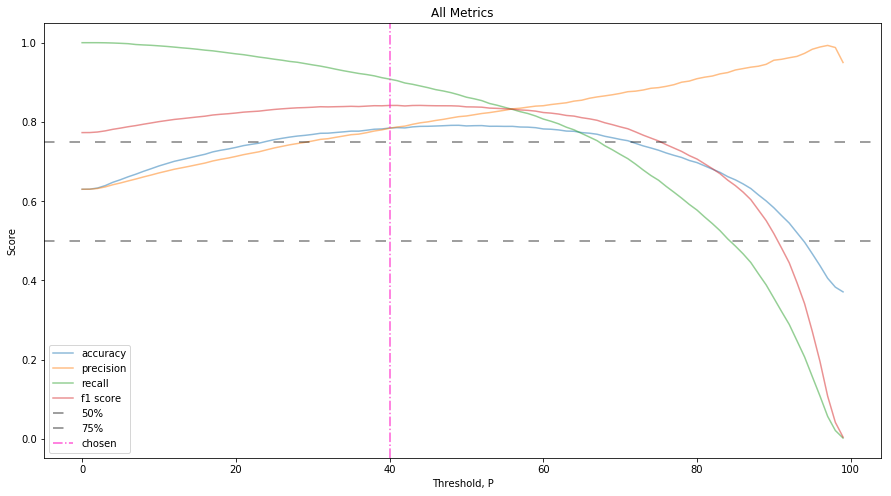

In [83]:
plt.figure(figsize = (15,8))
plt.plot(range(100), acc, label='accuracy', alpha=0.5)
plt.plot(range(100), pre, label='precision', alpha=0.5)
plt.plot(range(100), rec, label='recall', alpha=0.5)
plt.plot(range(100), f1s, label='f1 score', alpha=0.5)
plt.axhline(0.50, color='k', alpha=0.5, linestyle='--', dashes=(7,10), label='50%')
plt.axhline(0.75, color='k', alpha=0.5, linestyle='--', dashes=(7,10), label='75%')
plt.axvline(40, color='#ff33cc', alpha=0.8, linestyle='-.', label='chosen')
plt.title('All Metrics')
plt.xlabel('Threshold, P')
plt.ylabel('Score')
plt.legend()
plt.show()

# Final Model

In [84]:
final = GradientBoostingClassifier(**gs.best_params_).fit(X, y)

In [85]:
final_df = pd.read_csv('data/churn_test.csv')
final_df = eda(final_df)
fX, fy = split(final_df)

In [86]:
phat = final.predict_proba(fX)[:,1]
yhat = phat > (40/100)

In [87]:
accuracy_score(fy, yhat), precision_score(fy, yhat), recall_score(fy, yhat), roc_auc_score(fy, phat)

(0.7758257203092059,
 0.7720527617477329,
 0.9073147101566285,
 0.8544717419468525)

Final model has **over 90% on recall** *(our primary metric)* on unseen data, and **77% for accuracy and precision**.

# fin